# The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Acknowledgements:
This dataset has been referred from Kaggle: https://www.kaggle.com/c/titanic/data.

# Data

Overview
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

# Data Dictionary
survival	Survival	0 = No, 1 = Yes

pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

sex	Sex	

Age	Age in years	

sibsp	# of siblings / spouses aboard the Titanic	

parch	# of parents / children aboard the Titanic	

ticket	Ticket number	

fare	Passenger fare	

cabin	Cabin number	

embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

# Variable Notes

pclass: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

## Preparing the tools

We're going to use pandas, Matplotlib and NumPy for data analysis and manipulation.

In [208]:
# Import all the tools we need

# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

# Load Data

In [14]:
df = pd.read_csv("data/train.csv")
df.shape

(891, 12)

# Data Exploration

In [17]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### As we can see by looking at just the head and tail that We have some NaN values and our target column is "Survived"

In [25]:
df["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

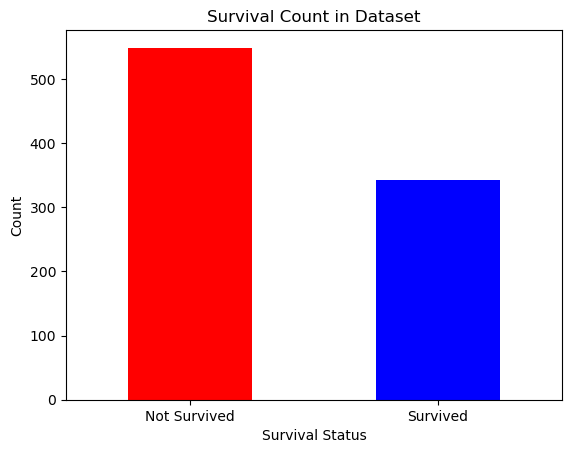

In [33]:
ax = df["Survived"].value_counts().plot(kind="bar",color=["red","blue"]);

ax.set_xticklabels(["Not Survived", "Survived"],rotation=0)

ax.set_xlabel("Survival Status")
ax.set_ylabel("Count")
ax.set_title("Survival Count in Dataset")

plt.show();

### Let's see if how many missing values we have and where?

In [37]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### By the first look we can fill the na of age with the median not the mean
see https://stats.stackexchange.com/questions/2547/why-is-median-age-a-better-statistic-than-mean-age#:~:text=Finally%2C%20the%20median%20gives%20us,can't%20say%20as%20much%2C

### We can drop the two missing embarked rows but i am not sure what to do with the cabin yet. let's continue..

In [42]:
df["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [51]:
pd.crosstab(df.Sex,df.Survived)

Survived,0,1
Sex,,
female,81,233
male,468,109


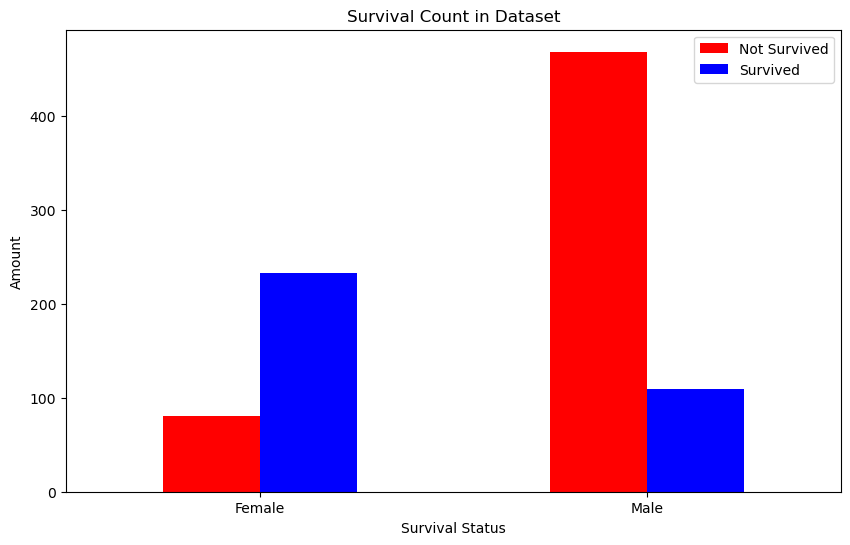

In [65]:
ax = pd.crosstab(df.Sex,df.Survived).plot(kind="bar",
                                     figsize=(10,6),
                                     color=["red","blue"]);
ax.set_xticklabels(["Female", "Male"],rotation=0)

ax.set_xlabel("Survival Status")
ax.set_ylabel("Amount")
ax.legend(["Not Survived","Survived"])
ax.set_title("Survival Count in Dataset")

plt.show();

### Interesting, most of the man died, and most of the woman survived, maybe thay evacuated the woman first as in the movie

<Axes: ylabel='Frequency'>

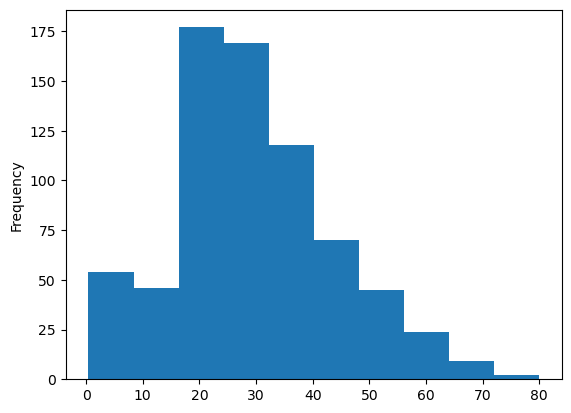

In [68]:
df.Age.plot.hist()

### Not the best distribution

In [75]:
df.corr()

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

### The Name column gets an error because it's not float, and it doesn't help us train the model anyway because all the names are unique there is no pattern in between, so that being said let's drop it

In [81]:
df = df.drop("Name",axis=1)

In [83]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [91]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [93]:
df.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

### Since we are missing only two values for embark, i will fill them with the most common one for good.

In [96]:
df["Embarked"] = df["Embarked"].fillna("S")

In [98]:
df.Embarked.value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [100]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

### Now let's fill the Na Age's with the median see https://stats.stackexchange.com/questions/2547/why-is-median-age-a-better-statistic-than-mean-age#:~:text=Finally%2C%20the%20median%20gives%20us,can't%20say%20as%20much%2C

In [103]:
df["Age"] = df["Age"].fillna(df["Age"].median())

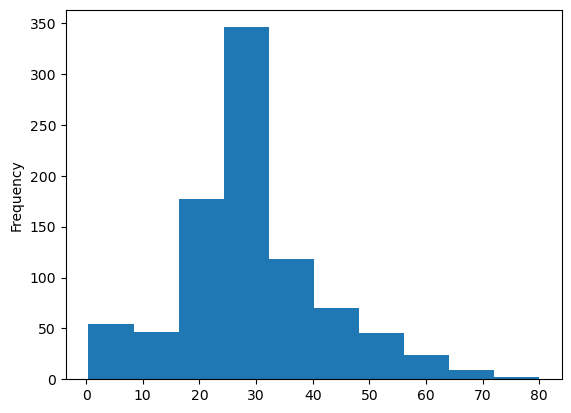

In [105]:
df.Age.plot.hist();

In [107]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

### Now that we handled Age, we're left with the Cabin column, even tho we are missing information on every row about Cabin, it is still an important information. So that being said let's do some feature engineering on cabin..

In [115]:
df.Cabin.value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

### The passengers that has cabins were probably wealthier so that preserve that informationf first

In [120]:
df["HasCabin"] = df["Cabin"].notna().astype(int)

In [122]:
df["HasCabin"].value_counts()

HasCabin
0    687
1    204
Name: count, dtype: int64

### We know that passengers with Cabins were wealthier but even if they had a cabin, the First Letter of the Cabin matters because some Cabins were worthed more than the others. So let's extract that information and the amount of Cabin that passenger had into new Columns

In [129]:
# If passenger has no Cabin fill it it U as in Unknown if not fill with the first letter of the cabin
df["CabinDeck"] = df["Cabin"].apply(lambda x: str(x)[0] if pd.notna(x) else "U")

In [131]:
# Count Number of Cabins passenger had if non fill with 0
df["CabinCount"] = df["Cabin"].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

### Now that we extracted the usefull information from the Cabin column, we don't need it anymore. So that let's drop it

In [134]:
df = df.drop("Cabin", axis=1)

In [136]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin,CabinDeck,CabinCount
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,0,U,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,1,C,1
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,U,0
3,4,1,1,female,35.0,1,0,113803,53.1000,S,1,C,1
4,5,0,3,male,35.0,0,0,373450,8.0500,S,0,U,0


In [138]:
# Let's convert the Sex aswell
df["Sex"] = df["Sex"].apply(lambda x: 1 if x == "male" else 0)

### Note that we used 0 as female and 1 for male

In [140]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin,CabinDeck,CabinCount
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,S,0,U,0
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C,1,C,1
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,S,0,U,0
3,4,1,1,0,35.0,1,0,113803,53.1000,S,1,C,1
4,5,0,3,1,35.0,0,0,373450,8.0500,S,0,U,0


In [143]:
df.Ticket.value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

### Ticket columns looks important since it's not unique for every value so that let's keep it as it is

In [148]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
HasCabin       0
CabinDeck      0
CabinCount     0
dtype: int64

### So far so good, we have no missing values anymore, now let's convert rest of our columns into number

In [155]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
HasCabin         int32
CabinDeck       object
CabinCount       int64
dtype: object

### Let's Turn the string and object values into category values

In [160]:
for label, content in df.items():
    if pd.api.types.is_object_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Sex          891 non-null    int64   
 4   Age          891 non-null    float64 
 5   SibSp        891 non-null    int64   
 6   Parch        891 non-null    int64   
 7   Ticket       891 non-null    category
 8   Fare         891 non-null    float64 
 9   Embarked     891 non-null    category
 10  HasCabin     891 non-null    int32   
 11  CabinDeck    891 non-null    category
 12  CabinCount   891 non-null    int64   
dtypes: category(3), float64(2), int32(1), int64(7)
memory usage: 91.7 KB


In [164]:
df.CabinDeck.value_counts()

CabinDeck
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [166]:
df.Ticket.cat.codes

0      523
1      596
2      669
3       49
4      472
      ... 
886    101
887     14
888    675
889      8
890    466
Length: 891, dtype: int16

### Now finally let's turn our categorical variables into numbers

In [170]:
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = pd.Categorical(content).codes + 1

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    int16  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    int8   
 10  HasCabin     891 non-null    int32  
 11  CabinDeck    891 non-null    int8   
 12  CabinCount   891 non-null    int64  
dtypes: float64(2), int16(1), int32(1), int64(7), int8(2)
memory usage: 69.7 KB


In [176]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin,CabinDeck,CabinCount
0,1,0,3,1,22.0,1,0,524,7.2500,3,0,9,0
1,2,1,1,0,38.0,1,0,597,71.2833,1,1,3,1
2,3,1,3,0,26.0,0,0,670,7.9250,3,0,9,0
3,4,1,1,0,35.0,1,0,50,53.1000,3,1,3,1
4,5,0,3,1,35.0,0,0,473,8.0500,3,0,9,0


### Let's make a correlation matrix to see the relations 

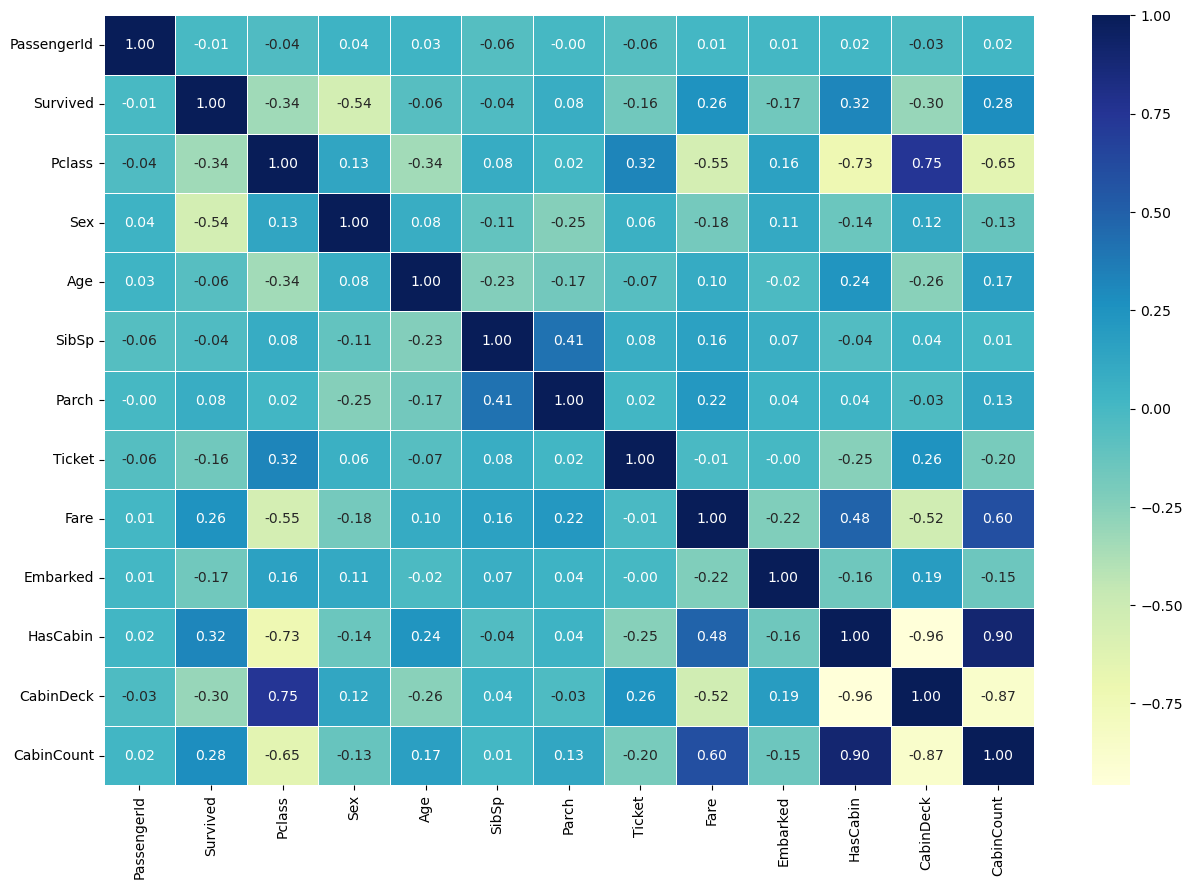

In [182]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                 annot = True,
                 linewidths = 0.5,
                 fmt = ".2f",
                 cmap = "YlGnBu")

### We can see from the correlation matrix that having Cabin is very important for surviving and as the Pclass number increases the survival rate drops
What was Pclass again:

pclass: A proxy for socio-economic status (SES)

* 1st = Upper
* 2nd = Middle
* 3rd = Lower
  
Summary, more of the wealthier people survived.

# Great now that we are done with exploring and engineering our data, let's dive into modelling

# Modelling

In [194]:
# Split data into X & y

X = df.drop("Survived",axis=1)
y = df["Survived"]

In [196]:
# Splitting our data into train and test sets
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X,y)
len(X_train), len(X_test), len(y_train), len(y_test)

(668, 223, 668, 223)

### Time to find a good algorithm to train our model
See: https://scikit-learn.org/1.5/machine_learning_map.html#choosing-the-right-estimator

Models are going to be tested
1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier

In [280]:
# Put models in a dictionary

models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Hist Gradient Boost": HistGradientBoostingClassifier(),
          "Extra Trees": ExtraTreesClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "SVC rbf": SVC(kernel='rbf')}

# Create a function to fit and score the models in our dict

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models. with the given train and test data.
    """
    np.random.seed(42)

    # Create an empty dict to keep model scores
    model_scores = {}

    # Loop through models
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        # Evaluate the model and append it's score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [282]:
model_scores = fit_and_score(models = models,
                             X_train = X_train,
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)
model_scores

C:\Users\asus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.7802690582959642,
 'KNN': 0.6681614349775785,
 'Random Forest': 0.8295964125560538,
 'Hist Gradient Boost': 0.8251121076233184,
 'Extra Trees': 0.8295964125560538,
 'Decision Tree': 0.7354260089686099,
 'SVC rbf': 0.6816143497757847}

# Model Comparison

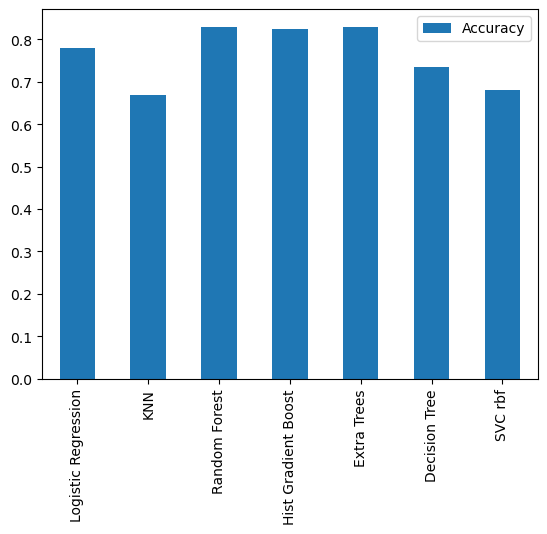

In [285]:
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare.T.plot.bar();

# Now let's dive into Hyperparameter tuning

In [300]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {
    "n_estimators": np.arange(50, 1001, 50),  # More granular steps
    "max_depth": [None, 3, 5, 10, 20, 30],  # Added 30 for better control
    "min_samples_split": [2, 5, 10, 15],  # Balanced values
    "min_samples_leaf": [1, 2, 5, 10]  # Prevent overly small leaves
}

# Set up RandomizedSearchCV
gs_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),  # Ensures reproducibility
    param_distributions=rf_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all CPU cores
    n_iter=20,  # Number of random samples (reduces computation)
    verbose=2,  # More detailed output
    random_state=42  # Ensures consistent results
)
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000])},
                   random_state=42, verbose=2)

In [331]:
gs_rf.score(X_test, y_test)

0.8295964125560538

## Evaluating our tuned machine learning classifier, beyon accuracy

* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-Score

In [334]:
y_preds = gs_rf.predict(X_test)

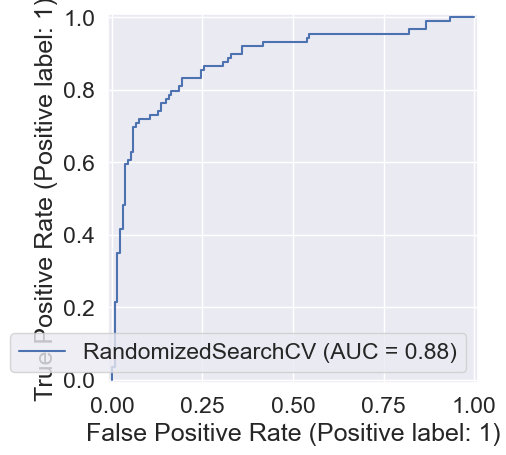

In [340]:
RocCurveDisplay.from_estimator(
   gs_rf, X_test, y_test)

In [342]:
# Confusion matrix
print(confusion_matrix(y_test, y_preds))

[[120  14]
 [ 24  65]]


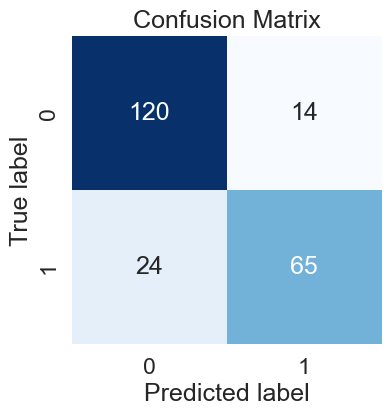

In [344]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    cm = confusion_matrix(y_test, y_preds)
    
    # Plot heatmap with integer formatting
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

# Call function
plot_conf_mat(y_test, y_preds)

In [346]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       134
           1       0.82      0.73      0.77        89

    accuracy                           0.83       223
   macro avg       0.83      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223



In [348]:
# Check best hyperparameters
gs_rf.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': None}

In [352]:
# Create a new classifier with best parameters
clf = RandomForestClassifier(n_estimators = 1000,
                        min_samples_split =  2,
                        min_samples_leaf = 2,
                        max_depth = None)

In [362]:
# Method for Cross-validated scores
scoring_types = {"accuracy score: ":"accuracy",
                 "precision score: ":"precision",
                 "recall score: ":"recall",
                 "f1 score: ":"f1"
                 }
scoring_results = {}
def cross_validator(model,X,y):
    for name, scoring_t in scoring_types.items():
        cv_scoring = cross_val_score(model,
                             X,
                             y,
                             cv=5,
                             scoring=scoring_t)
        cv_scoring = np.mean(cv_acc)
        scoring_results[name] = cv_scoring
    return scoring_results

In [366]:
all_scoring_results = cross_validator(clf,X,y)

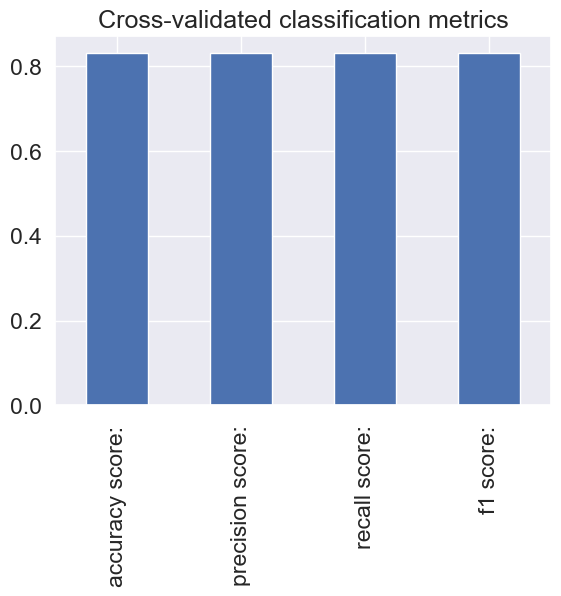

In [368]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame(all_scoring_results,
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-validated classification metrics",
                      legend=False);

In [406]:
df_test = pd.read_csv("data/test.csv")
df_test.shape
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [408]:
clf.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Cabin
- Name
Feature names seen at fit time, yet now missing:
- CabinCount
- CabinDeck
- HasCabin


In [411]:
## We have to convert the test dataset into the shape of the training dataset, let's create a function for it
def prepare_data(data):
    data = data.drop("Name",axis=1)
    data["Embarked"] = data["Embarked"].fillna("S")
    data["Age"] = data["Age"].fillna(data["Age"].median())
    data["HasCabin"] = data["Cabin"].notna().astype(int)
    # If passenger has no Cabin fill it it U as in Unknown if not fill with the first letter of the cabin
    data["CabinDeck"] = data["Cabin"].apply(lambda x: str(x)[0] if pd.notna(x) else "U")
    # Count Number of Cabins passenger had if non fill with 0
    data["CabinCount"] = data["Cabin"].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    data = data.drop("Cabin", axis=1)
    # Let's convert the Sex aswell
    data["Sex"] = data["Sex"].apply(lambda x: 1 if x == "male" else 0)
    for label, content in data.items():
        if pd.api.types.is_object_dtype(content):
            data[label] = content.astype("category").cat.as_ordered()
    for label, content in data.items():
        if not pd.api.types.is_numeric_dtype(content):
            data[label] = pd.Categorical(content).codes + 1
    return data

In [413]:
df_test = prepare_data(df_test)

In [425]:
predictions = clf.predict(df_test)

In [427]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
